# Exploratory Data Analysis: DIRPS & Falciparum

In [24]:
# data science
from scipy.stats import norm
import numpy as np
import pandas as pd


# utilities
from pathlib import Path
from termcolor import colored
from tqdm import tqdm
import gzip
import math
from dotenv import load_dotenv
import os

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns

In [25]:
# loading environment

# LOAD ENVIRONMENT
load_dotenv("paths.env")
DATABASE = os.getenv("DATABASE")
IRP_DB_PATH = os.getenv("IRP_DB")

assert os.path.isdir(DATABASE), "Invalid directory!"
assert os.path.isfile(IRP_DB_PATH), "Invalid path for irp database!"

In [5]:
assert 1==0

AssertionError: 

In [26]:
domains = ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
domain_colors = {
                'Viruses': '#b2ebeb',
                'Eukaryota': '#ffb2b2',
                'Archaea': '#b2b2ff',
                'Bacteria': '#b2d8b2'
}

In [313]:
irp_df = pd.read_csv("/storage/group/izg5139/default/irp_database_transfer.csv.gz")
irp_df.head()

/tmp/ipykernel_177451/2866282212.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  irp_df = pd.read_csv("/storage/group/izg5139/default/irp_database_transfer.csv.gz")


,speciesID,chromosome,start,end,arm_size,gap_size,sequenceof_arm,#assembly_accession,assembly_id,bioproject,...,organism_name,assembly_level,group,genome_size,gc_percent,total_gene_count,method,phylum,superkingdom,kingdom
0,GCF_000002515.2_ASM251v1_genomic,NC_006037.1,21717,21738,11,0,atgtatatata,GCF_000002515.2,G000002515,PRJNA13835,...,Kluyveromyces lactis,Complete Genome,fungi,10689156,38.5,5389,GCA,Ascomycota,Eukaryota,Fungi
1,GCF_000002515.2_ASM251v1_genomic,NC_006037.1,141115,141141,11,5,gattctgataa,GCF_000002515.2,G000002515,PRJNA13835,...,Kluyveromyces lactis,Complete Genome,fungi,10689156,38.5,5389,GCA,Ascomycota,Eukaryota,Fungi
2,GCF_000002515.2_ASM251v1_genomic,NC_006037.1,148944,148967,10,4,ttctttcatt,GCF_000002515.2,G000002515,PRJNA13835,...,Kluyveromyces lactis,Complete Genome,fungi,10689156,38.5,5389,GCA,Ascomycota,Eukaryota,Fungi
3,GCF_000002515.2_ASM251v1_genomic,NC_006037.1,151854,151885,14,4,aaattagcattagc,GCF_000002515.2,G000002515,PRJNA13835,...,Kluyveromyces lactis,Complete Genome,fungi,10689156,38.5,5389,GCA,Ascomycota,Eukaryota,Fungi
4,GCF_000002515.2_ASM251v1_genomic,NC_006037.1,153811,153858,24,0,acagaaagaagttgatcacgtgca,GCF_000002515.2,G000002515,PRJNA13835,...,Kluyveromyces lactis,Complete Genome,fungi,10689156,38.5,5389,GCA,Ascomycota,Eukaryota,Fungi


In [314]:
irp_df[irp_df['superkingdom'].isna()]

,speciesID,chromosome,start,end,arm_size,gap_size,sequenceof_arm,#assembly_accession,assembly_id,bioproject,...,organism_name,assembly_level,group,genome_size,gc_percent,total_gene_count,method,phylum,superkingdom,kingdom


In [315]:
irp_df.isnull().sum()

speciesID                  0
chromosome                 0
start                      0
end                        0
arm_size                   0
gap_size                   0
sequenceof_arm             0
#assembly_accession        0
assembly_id                0
bioproject                 0
taxid                      0
species_taxid              0
organism_name              0
assembly_level             0
group                      0
genome_size                0
gc_percent                 0
total_gene_count           0
method                     0
phylum                 52898
superkingdom               0
kingdom                    1
dtype: int64

In [316]:
empty_assemblies = pd.read_csv("/storage/group/izg5139/default/nicole/inverted_repeats/paper_data/empty_assemblies.csv.gz")
empty_assemblies.shape

(30876, 15)

In [317]:
def add_empty_assemblies(df):
    global empty_assemblies
    return pd.concat([df, empty_assemblies.set_index("#assembly_accession")[["superkingdom"]]], axis=0)

## Inverted Repeats Spawning Sites

In [319]:
chromosome_metadata = pd.read_csv("/storage/group/izg5139/default/nicole/inverted_repeats/genomic_data/chromosome_metadata.txt", delimiter="\t")
chromosome_metadata.loc[:, "assembly_id"] = chromosome_metadata["#assembly_accession"].str.extract("GC[AF]_(\d+\.\d+)")

chromosome_metadata_ = chromosome_metadata.groupby("#assembly_accession", as_index=False)\
                .agg(genome_size_n=("total_bp", "sum"))
chromosome_metadata = chromosome_metadata.merge(chromosome_metadata_, on="#assembly_accession", how="left")

irp_coverage = irp_df.groupby("#assembly_accession", as_index=False)\
                    .agg({"arm_size": lambda ds: ds.sum() * 2 ,
                            "gap_size": lambda ds: ds.sum(),
                              "kingdom": "first",
                              "superkingdom": "first",
                             "organism_name": "first",
                         })\
                    .assign(total_ir=lambda df: df['arm_size'] + df['gap_size'])
irp_coverage = irp_coverage.merge(chromosome_metadata[["#assembly_accession", "genome_size_n"]].drop_duplicates(),
                                  on="#assembly_accession")
irp_coverage["coverage"] = 1000 * irp_coverage["total_ir"].div(irp_coverage["genome_size_n"])
irp_coverage

,#assembly_accession,arm_size,gap_size,kingdom,superkingdom,organism_name,total_ir,genome_size_n,coverage
0,GCA_000006845.1,11470,1824,Eubacteria,Bacteria,Neisseria gonorrhoeae FA 1090,13294,2153922,6.171997
1,GCA_000006865.1,13388,2207,Eubacteria,Bacteria,Lactococcus lactis subsp. lactis Il1403,15595,2365589,6.592439
2,GCA_000006925.2,11706,2354,Eubacteria,Bacteria,Shigella flexneri 2a str. 301,14060,4828820,2.911684
3,GCA_000007025.1,4410,707,Eubacteria,Bacteria,Rickettsia conorii str. Malish 7,5117,1268755,4.033088
4,GCA_000007085.1,7022,1311,Eubacteria,Bacteria,Caldanaerobacter subterraneus subsp. tengconge...,8333,2689445,3.098409
...,...,...,...,...,...,...,...,...,...
76988,GCF_963422545.1,22340,3388,Eubacteria,Bacteria,uncultured Flavobacterium sp.,25728,5236164,4.913521
76989,GCF_963457545.1,1460,255,Archaeabacteria,Archaea,Nitrosopumilus sp.,1715,2359279,0.726917
76990,GCF_963457575.1,7146,1147,Eubacteria,Bacteria,uncultured Brevundimonas sp.,8293,4103361,2.021026
76991,GCF_963457595.1,2468,420,Eubacteria,Bacteria,Candidatus Neptunochlamydia sp. REUL1,2888,2029244,1.423190


In [323]:
irp_coverage.sort_values(by=['coverage'], ascending=False).query("kingdom != 'Unclassified Viruses'").head(60)

,#assembly_accession,arm_size,gap_size,kingdom,superkingdom,organism_name,total_ir,genome_size_n,coverage
42521,GCA_031202825.1,392,4,Orthornavirae,Viruses,Kummerowia striata partitivirus,396,2196,180.327869
12723,GCA_004056055.1,294,2,Shotokuvirae,Viruses,Beak and feather disease virus,296,2001,147.926037
30223,GCA_024172815.1,8094,29,Heunggongvirae,Viruses,Klebsiella phage GTai-2021a,8123,58864,137.996059
61599,GCF_013087775.1,480,0,Shotokuvirae,Viruses,Equine parvovirus H,480,5308,90.429540
41956,GCA_031124205.1,510,0,Shotokuvirae,Viruses,Human bocavirus 1,510,5671,89.931229
24799,GCA_018595505.1,542,49,Shotokuvirae,Viruses,Black medic leaf roll virus,591,8106,72.908956
42479,GCA_031201625.1,202,43,Orthornavirae,Viruses,Erysiphe necator associated narnavirus 39,245,3469,70.625541
50455,GCF_000914235.1,462,88,Shotokuvirae,Viruses,Pea necrotic yellow dwarf virus,550,7896,69.655522
42490,GCA_031201815.1,126,16,Orthornavirae,Viruses,Erysiphe necator associated narnavirus 7,142,2156,65.862709
42500,GCA_031202105.1,354,11,Orthornavirae,Viruses,Kummerowia striata luteovirus,365,5588,65.318540


In [11]:
chromosome_metadata['#assembly_accession'].nunique()

108429

In [12]:
irp_df["chromosome"] = irp_df["chromosome"].str.strip()

In [13]:
irp_df = irp_df[["#assembly_accession", "chromosome", "start", "end", "organism_name", "arm_size", "genome_size", "gc_percent", "phylum", "kingdom", "superkingdom", "sequenceof_arm"]]\
                                            .merge(chromosome_metadata, 
                                                    on=["#assembly_accession", "chromosome"], 
                                                    how="left"
                                            )
irp_df

,#assembly_accession,chromosome,start,end,organism_name,arm_size,genome_size,gc_percent,phylum,kingdom,superkingdom,sequenceof_arm,total_bp,adenine,guanine,cytosine,thymine,N,assembly_id
0,GCF_000002515.2,NC_006037.1,21717,21738,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,Eukaryota,atgtatatata,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
1,GCF_000002515.2,NC_006037.1,141115,141141,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,Eukaryota,gattctgataa,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
2,GCF_000002515.2,NC_006037.1,148944,148967,Kluyveromyces lactis,10,10689156,38.5,Ascomycota,Fungi,Eukaryota,ttctttcatt,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
3,GCF_000002515.2,NC_006037.1,151854,151885,Kluyveromyces lactis,14,10689156,38.5,Ascomycota,Fungi,Eukaryota,aaattagcattagc,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
4,GCF_000002515.2,NC_006037.1,153811,153858,Kluyveromyces lactis,24,10689156,38.5,Ascomycota,Fungi,Eukaryota,acagaaagaagttgatcacgtgca,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146611,GCF_000971565.1,NZ_CP011249.1,55400,55425,Agrobacterium fabacearum,10,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,catcgatctc,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1
24146612,GCF_000971565.1,NZ_CP011249.1,62797,62826,Agrobacterium fabacearum,12,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,ggctgccgtcgg,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1
24146613,GCF_000971565.1,NZ_CP011249.1,90323,90350,Agrobacterium fabacearum,10,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,tgggaggtcg,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1
24146614,GCF_000971565.1,NZ_CP011249.1,115239,115267,Agrobacterium fabacearum,12,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,acgtccgataat,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1


In [14]:
irp_df[irp_df['total_bp'].isna()]['#assembly_accession'].nunique()

1

In [15]:
problematic = irp_df.query("start > total_bp | end > total_bp | end < start")["#assembly_accession"].unique()
problematic

array(['GCA_003719575.1', 'GCA_019677325.2'], dtype=object)

In [16]:
print(irp_df.shape)
irp_df = irp_df[~irp_df['total_bp'].isna()].reset_index(drop=True)
print(irp_df.shape)
irp_df

(24146616, 19)
(24146027, 19)


,#assembly_accession,chromosome,start,end,organism_name,arm_size,genome_size,gc_percent,phylum,kingdom,superkingdom,sequenceof_arm,total_bp,adenine,guanine,cytosine,thymine,N,assembly_id
0,GCF_000002515.2,NC_006037.1,21717,21738,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,Eukaryota,atgtatatata,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
1,GCF_000002515.2,NC_006037.1,141115,141141,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,Eukaryota,gattctgataa,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
2,GCF_000002515.2,NC_006037.1,148944,148967,Kluyveromyces lactis,10,10689156,38.5,Ascomycota,Fungi,Eukaryota,ttctttcatt,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
3,GCF_000002515.2,NC_006037.1,151854,151885,Kluyveromyces lactis,14,10689156,38.5,Ascomycota,Fungi,Eukaryota,aaattagcattagc,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
4,GCF_000002515.2,NC_006037.1,153811,153858,Kluyveromyces lactis,24,10689156,38.5,Ascomycota,Fungi,Eukaryota,acagaaagaagttgatcacgtgca,1062590.0,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146022,GCF_000971565.1,NZ_CP011249.1,55400,55425,Agrobacterium fabacearum,10,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,catcgatctc,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1
24146023,GCF_000971565.1,NZ_CP011249.1,62797,62826,Agrobacterium fabacearum,12,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,ggctgccgtcgg,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1
24146024,GCF_000971565.1,NZ_CP011249.1,90323,90350,Agrobacterium fabacearum,10,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,tgggaggtcg,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1
24146025,GCF_000971565.1,NZ_CP011249.1,115239,115267,Agrobacterium fabacearum,12,5668655,58.0,Pseudomonadota,Eubacteria,Bacteria,acgtccgataat,194264.0,43864.0,54104.0,52066.0,44230.0,0.0,000971565.1


In [17]:
irp_df.loc[:, "start_bin"] = irp_df[["total_bp", "start"]]\
                            .apply(lambda x: math.ceil(x["start"] * 100 / x["total_bp"]), axis=1)

irp_df.loc[:, "end_bin"] = irp_df[["total_bp", "end"]]\
        .apply(lambda x: math.ceil(x["end"] * 100 / x["total_bp"]), axis=1)

In [18]:
irp_df.loc[:, "bin_size"] = irp_df["total_bp"].apply(lambda x: x/100)

In [19]:
irp_df.duplicated().sum()

0

In [20]:
irp_df.loc[:, "ta_percent"] = irp_df["sequenceof_arm"].apply(lambda x: (x.count("a") + x.count("t"))/len(x))
irp_df.head()

,#assembly_accession,chromosome,start,end,organism_name,arm_size,genome_size,gc_percent,phylum,kingdom,...,adenine,guanine,cytosine,thymine,N,assembly_id,start_bin,end_bin,bin_size,ta_percent
0,GCF_000002515.2,NC_006037.1,21717,21738,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,...,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2,3,3,10625.9,0.909091
1,GCF_000002515.2,NC_006037.1,141115,141141,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,...,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2,14,14,10625.9,0.727273
2,GCF_000002515.2,NC_006037.1,148944,148967,Kluyveromyces lactis,10,10689156,38.5,Ascomycota,Fungi,...,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2,15,15,10625.9,0.800000
3,GCF_000002515.2,NC_006037.1,151854,151885,Kluyveromyces lactis,14,10689156,38.5,Ascomycota,Fungi,...,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2,15,15,10625.9,0.714286
4,GCF_000002515.2,NC_006037.1,153811,153858,Kluyveromyces lactis,24,10689156,38.5,Ascomycota,Fungi,...,321553.0,207795.0,208091.0,325151.0,0.0,000002515.2,15,15,10625.9,0.583333


In [172]:
accessions = irp_df['#assembly_accession'].unique().tolist()
count_bins = {}
total_bins = 100
for accession in accessions:
    for bin in range(1, total_bins+1):
        count_bins.update({(accession, bin): 0})

In [173]:
  
for _, row in tqdm(irp_df.iterrows(), total=irp_df.shape[0]):

    accession = row['#assembly_accession']
    sequence = row['sequenceof_arm']
    start = row['start_bin']
    end = row['end_bin']

    for bin in range(start, end+1):
        count_bins[accession, bin] += 1

100%|██████████| 24145421/24145421 [16:59<00:00, 23690.20it/s]


In [174]:
count_bins = pd.Series(count_bins).to_frame(name="counts").reset_index()
count_bins

,level_0,level_1,counts
0,GCF_000002515.2,1,1
1,GCF_000002515.2,2,1
2,GCF_000002515.2,3,3
3,GCF_000002515.2,4,7
4,GCF_000002515.2,5,4
...,...,...,...
7699095,GCF_000971565.1,96,3
7699096,GCF_000971565.1,97,3
7699097,GCF_000971565.1,98,7
7699098,GCF_000971565.1,99,3


In [176]:
count_bins = count_bins.rename(columns={"level_0": "#assembly_accession",
                                        "level_1": "bin"})

In [27]:
bin_counts = None
irp_data = irp_df[["#assembly_accession", "start_bin", "end_bin",  "superkingdom"]].copy()

for idx in tqdm(range(100)):
    temp = irp_data.groupby(["#assembly_accession", "end_bin"]).agg(counts=("superkingdom", "count"),
                                                                   )
    irp_data["end_bin"] = irp_data["end_bin"] - 1
    irp_data = irp_data[irp_data["end_bin"] >= irp_data["start_bin"]]

    if bin_counts is None:
        bin_counts = temp
    else:
        bin_counts = bin_counts.merge(temp, 
                                      left_index=True, 
                                      right_index=True, 
                                      suffixes=("", "_additional"), 
                                      how="outer")\
                                .fillna(0.0)\
                                .astype(int)
        
        bin_counts["counts"] += bin_counts["counts_additional"]
        bin_counts.drop(columns=["counts_additional"], inplace=True)

    if len(irp_data) == 0:
        break

    
bin_counts = bin_counts.reset_index()
bin_counts.head()

 99%|█████████▉| 99/100 [02:01<00:01,  1.23s/it]


,#assembly_accession,end_bin,counts
0,GCA_000006845.1,1,3
1,GCA_000006845.1,2,3
2,GCA_000006845.1,3,3
3,GCA_000006845.1,4,6
4,GCA_000006845.1,5,3


In [179]:
count_bins.shape[0] // 100

76991

In [181]:
count_bins['#assembly_accession'].unique().shape[0]

76991

In [177]:
count_bins = count_bins.rename(columns={'level_0': '#assembly_accession',
                                        'level_1': 'bin'})\
                .sort_values(by=['#assembly_accession', 'bin'], ascending=True)\
                .reset_index(drop=True)
count_bins

,#assembly_accession,bin,counts
0,GCA_000006845.1,1,3
1,GCA_000006845.1,2,3
2,GCA_000006845.1,3,3
3,GCA_000006845.1,4,6
4,GCA_000006845.1,5,3
...,...,...,...
7699095,GCF_963457605.1,96,4
7699096,GCF_963457605.1,97,5
7699097,GCF_963457605.1,98,6
7699098,GCF_963457605.1,99,3


In [34]:
accession_data = irp_df[["#assembly_accession", "organism_name", "phylum", "kingdom", "superkingdom", "genome_size", "gc_percent"]].groupby("#assembly_accession", as_index=False)\
                    .agg({"organism_name": "first",
                          "phylum": "first",
                          "kingdom": "first",
                          "superkingdom": "first",
                          "genome_size": "first", 
                          "gc_percent": "first"
                         })
accession_data

,#assembly_accession,organism_name,phylum,kingdom,superkingdom,genome_size,gc_percent
0,GCA_000006845.1,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria,2153922,52.5
1,GCA_000006865.1,Lactococcus lactis subsp. lactis Il1403,Bacillota,Eubacteria,Bacteria,2365589,35.0
2,GCA_000006925.2,Shigella flexneri 2a str. 301,Pseudomonadota,Eubacteria,Bacteria,4828820,50.5
3,GCA_000007025.1,Rickettsia conorii str. Malish 7,Pseudomonadota,Eubacteria,Bacteria,1268755,32.0
4,GCA_000007085.1,Caldanaerobacter subterraneus subsp. tengconge...,Bacillota,Eubacteria,Bacteria,2689445,37.5
...,...,...,...,...,...,...,...
76986,GCF_963422545.1,uncultured Flavobacterium sp.,Bacteroidota,Eubacteria,Bacteria,5236164,33.0
76987,GCF_963457545.1,Nitrosopumilus sp.,Nitrososphaerota,Archaeabacteria,Archaea,2359279,35.0
76988,GCF_963457575.1,uncultured Brevundimonas sp.,Pseudomonadota,Eubacteria,Bacteria,4103361,66.5
76989,GCF_963457595.1,Candidatus Neptunochlamydia sp. REUL1,Chlamydiota,Eubacteria,Bacteria,2029244,42.0


In [182]:
total_bin_counts = count_bins.groupby("#assembly_accession").agg(total_occurrences=("counts", "sum"))
total_bin_counts

,total_occurrences
#assembly_accession,
GCA_000006845.1,431
GCA_000006865.1,540
GCA_000006925.2,516
GCA_000007025.1,179
GCA_000007085.1,284
...,...
GCF_963422545.1,849
GCF_963457545.1,69
GCF_963457575.1,321


In [183]:
count_bins = count_bins.merge(total_bin_counts, 
                              how="left", 
                              left_on="#assembly_accession", 
                              right_index=True)
count_bins

,#assembly_accession,bin,counts,total_occurrences
0,GCA_000006845.1,1,3,431
1,GCA_000006845.1,2,3,431
2,GCA_000006845.1,3,3,431
3,GCA_000006845.1,4,6,431
4,GCA_000006845.1,5,3,431
...,...,...,...,...
7699095,GCF_963457605.1,96,4,345
7699096,GCF_963457605.1,97,5,345
7699097,GCF_963457605.1,98,6,345
7699098,GCF_963457605.1,99,3,345


In [184]:
count_bins.loc[:, "bin_percentage"] = 100 * count_bins["counts"].div(count_bins["total_occurrences"])
count_bins

,#assembly_accession,bin,counts,total_occurrences,bin_percentage
0,GCA_000006845.1,1,3,431,0.696056
1,GCA_000006845.1,2,3,431,0.696056
2,GCA_000006845.1,3,3,431,0.696056
3,GCA_000006845.1,4,6,431,1.392111
4,GCA_000006845.1,5,3,431,0.696056
...,...,...,...,...,...
7699095,GCF_963457605.1,96,4,345,1.159420
7699096,GCF_963457605.1,97,5,345,1.449275
7699097,GCF_963457605.1,98,6,345,1.739130
7699098,GCF_963457605.1,99,3,345,0.869565


In [65]:
count_bins = count_bins.iloc[:, :5]
count_bins.head()

,#assembly_accession,bin,counts,total_occurrences,bin_percentage
0,GCA_000006845.1,1,3,431,0.696056
1,GCA_000006845.1,2,3,431,0.696056
2,GCA_000006845.1,3,3,431,0.696056
3,GCA_000006845.1,4,6,431,1.392111
4,GCA_000006845.1,5,3,431,0.696056


In [186]:
count_bins = count_bins.merge(irp_df[["#assembly_accession", "gc_percent", "genome_size", "organism_name", "phylum", "kingdom", "superkingdom"]].drop_duplicates(), 
                             on="#assembly_accession",
                             how="left"
                )
count_bins                                     

,#assembly_accession,bin,counts,total_occurrences,bin_percentage,gc_percent,genome_size,organism_name,phylum,kingdom,superkingdom
0,GCA_000006845.1,1,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
1,GCA_000006845.1,2,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
2,GCA_000006845.1,3,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
3,GCA_000006845.1,4,6,431,1.392111,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
4,GCA_000006845.1,5,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...
7699095,GCF_963457605.1,96,4,345,1.159420,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria
7699096,GCF_963457605.1,97,5,345,1.449275,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria
7699097,GCF_963457605.1,98,6,345,1.739130,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria
7699098,GCF_963457605.1,99,3,345,0.869565,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria


In [187]:
count_bins.query("organism_name == 'Plasmodium falciparum 3D7'")

,#assembly_accession,bin,counts,total_occurrences,bin_percentage,gc_percent,genome_size,organism_name,phylum,kingdom,superkingdom
4665100,GCF_000002765.5,1,39,43173,0.090334,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
4665101,GCF_000002765.5,2,152,43173,0.352072,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
4665102,GCF_000002765.5,3,237,43173,0.548954,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
4665103,GCF_000002765.5,4,303,43173,0.701828,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
4665104,GCF_000002765.5,5,390,43173,0.903342,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
...,...,...,...,...,...,...,...,...,...,...,...
4665195,GCF_000002765.5,96,316,43173,0.731939,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
4665196,GCF_000002765.5,97,277,43173,0.641605,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
4665197,GCF_000002765.5,98,232,43173,0.537373,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota
4665198,GCF_000002765.5,99,144,43173,0.333542,19.0,23292622,Plasmodium falciparum 3D7,Apicomplexa,Protista,Eukaryota


In [68]:
count_bins.to_csv("/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/bin_counts_percentage.csv.gz", compression="gzip", index=False, mode="w")

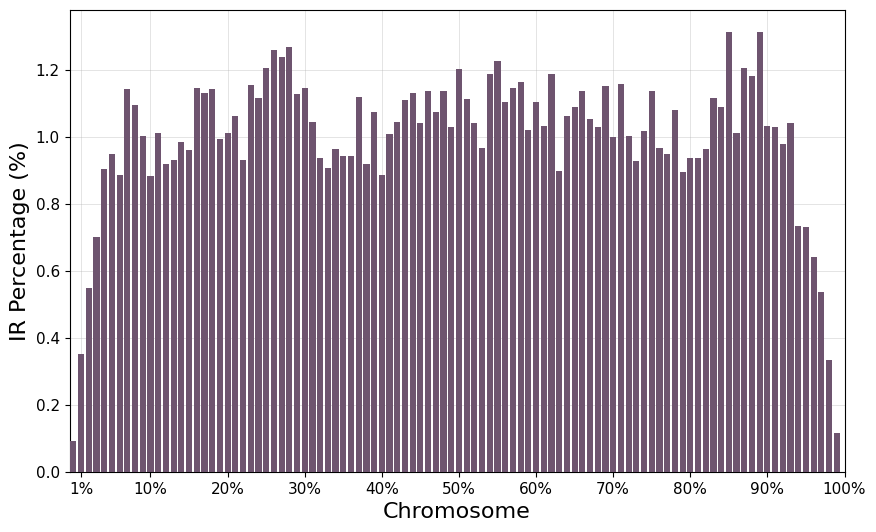

In [204]:
temp = count_bins[count_bins['#assembly_accession'] == 'GCF_000002765.5']\
                            .groupby("bin", as_index=False)\
                            .agg({"bin_percentage": "mean"})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=temp, 
                                    x="bin", 
                                    y="bin_percentage", 
                                    color='#725073',
                                    dodge=0.00001,
                                    ax=ax, zorder=3)
ax.grid(axis='both', lw=0.4, alpha=0.6, zorder=0)
ax.set_xticks([1] + list(range(10, 101, 10)), ["1%"] + [f"{i}%"for i in range(10, 101, 10)])
# ax.set_xticks(range(100), [f"{i}%" if i in {20, 40, 60, 80, 100} else ("0%" if i == 1 else "")  for i in range(1, 101)])
ax.set_xlabel("Chromosome")
ax.set_ylabel("IR Percentage (%)")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.tick_params(axis="both", which="major", labelsize=11)
fig.savefig("falciparum_irp_distribution.png", bbox_inches='tight')

## Falciparum Distribution

In [219]:
count_bins.kingdom.unique()

array(['Eubacteria', 'Archaeabacteria', 'Metagenomes/Other', 'Fungi',
       'Unclassified Viruses', 'Heunggongvirae', 'Shotokuvirae',
       'Orthornavirae', 'Bamfordvirae', 'Plantae', 'Animalia',
       'Sangervirae', 'Zilligvirae', 'Loebvirae', 'Protista',
       'Pararnavirae', 'Trapavirae', 'Helvetiavirae', nan], dtype=object)

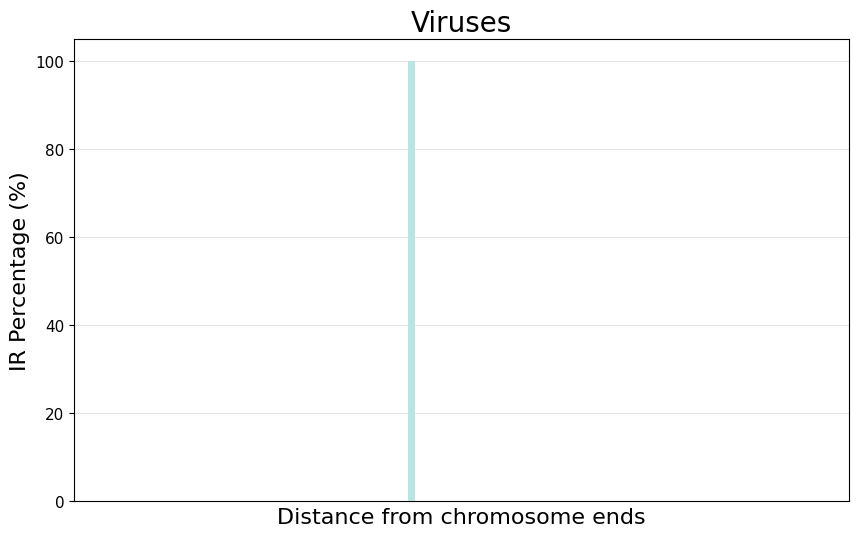

In [333]:
temp = count_bins[count_bins['#assembly_accession'] == 'GCA_009688305.1']\
                            .groupby("bin", as_index=False)\
                            .agg({"bin_percentage": "mean"})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=temp, 
                                    x="bin", 
                                    y="bin_percentage", 
                                    color=domain_colors["Viruses"],
                                    dodge=False, width=0.87, ax=ax, zorder=3)
ax.set_xticks([])
ax.set_title("Viruses")
ax.title.set_size(20)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Distance from chromosome ends")
ax.set_ylabel("IR Percentage (%)")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.tick_params(axis="both", which="major", labelsize=11)

# Gini Index

In [74]:
count_bins.head()

,#assembly_accession,bin,counts,total_occurrences,bin_percentage,gc_percent,genome_size,organism_name,phylum,kingdom,superkingdom
0,GCA_000006845.1,1,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
1,GCA_000006845.1,2,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
2,GCA_000006845.1,3,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
3,GCA_000006845.1,4,6,431,1.392111,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
4,GCA_000006845.1,5,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria


In [309]:
irp_df = irp_df[~irp_df['#assembly_accession'].isin({"GCA_003719575.1", "GCA_019677325.2"})]

In [312]:
irp_df.columns

Index(['#assembly_accession', 'chromosome', 'start', 'end', 'organism_name',
       'arm_size', 'genome_size', 'gc_percent', 'phylum', 'kingdom',
       'superkingdom', 'sequenceof_arm', 'total_bp', 'adenine', 'guanine',
       'cytosine', 'thymine', 'N', 'assembly_id', 'start_bin', 'end_bin',
       'bin_size', 'ta_percent'],
      dtype='object')

In [83]:
irp_df.query("total_bp < end")['#assembly_accession'].unique()

array(['GCA_003719575.1', 'GCA_019677325.2'], dtype=object)

In [76]:
count_bins.groupby("#assembly_accession").agg({"counts": "count"}).sort_values(by=['counts'])

,counts
#assembly_accession,
GCA_002745655.1,1
GCA_002755415.1,1
GCA_002755435.1,1
GCA_002755495.1,1
GCA_002745055.1,1
...,...
GCF_004009575.1,100
GCF_004009555.1,100
GCF_004009535.1,100


In [210]:
def calculate_gini(vals, total_bins=100):
    vals = [val for val in vals]

    if len(vals) < total_bins:
        vals += [0.0 for _ in range(total_bins - len(vals))]

    assert len(vals) == total_bins, f"{len(vals)} != {total_bins}"
    total = float(sum(vals))
    vals.extend([0])
    vals.sort()
    length = float(len(vals)) - 1
    vals = [val/total for val in vals]
    cumulative = [sum(vals[:i]) for i in range(1,len(vals)+1,1)]
    return 1 - 2*sum([(i+j)/(2*length) for i , j in zip(cumulative[1:],cumulative[:-1])])

In [211]:
calculate_gini([1000,2000,3000,4000,5000,6000,7000], 7)

0.2857142857142857

In [72]:
def calculate_theil(stream, total_bins):
    stream = list(stream)
    if len(stream) < total_bins:
        stream += [0.0 for _ in range(total_bins - len(stream))]

    assert len(stream) == total_bins, f"{len(stream)} != {total_bins}"
    stream = np.array(stream)
    mean = stream.mean()
    
    return np.mean( stream / mean * np.log( stream / mean ) )

In [329]:
count_bins.loc[:, "kingdom_"] = count_bins[["kingdom", "superkingdom"]].apply(lambda row: 'Viruses' if row['superkingdom'] == 'Viruses' \
                                                                                           else row['kingdom'], axis=1
                                                                              )

In [121]:
count_bins = count_bins[~count_bins['#assembly_accession'].isin({"GCA_019677325.2", "GCA_003719575.1"})]
count_bins

,#assembly_accession,bin,counts,total_occurrences,bin_percentage,gc_percent,genome_size,organism_name,phylum,kingdom,superkingdom
0,GCA_000006845.1,1,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
1,GCA_000006845.1,2,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
2,GCA_000006845.1,3,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
3,GCA_000006845.1,4,6,431,1.392111,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
4,GCA_000006845.1,5,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...
4279754,GCF_963457605.1,96,4,345,1.159420,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria
4279755,GCF_963457605.1,97,5,345,1.449275,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria
4279756,GCF_963457605.1,98,6,345,1.739130,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria
4279757,GCF_963457605.1,99,3,345,0.869565,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria


In [101]:
count_bins_phylum = count_bins.query("kingdom != 'Unclassified Viruses' & superkingdom == 'Viruses'").groupby(["kingdom", "bin"], as_index=False)\
                            .agg({
                                 "superkingdom": "first", 
                                  "total_occurrences": "sum",
                                  "counts": "sum"
                                 })\
                    .sort_values(by=['kingdom', 'bin'], ascending=True)
count_bins_phylum

,kingdom,bin,superkingdom,total_occurrences,counts
0,Bamfordvirae,1,Viruses,16881,389
1,Bamfordvirae,2,Viruses,16295,345
2,Bamfordvirae,3,Viruses,18857,660
3,Bamfordvirae,4,Viruses,16769,465
4,Bamfordvirae,5,Viruses,50549,3140
...,...,...,...,...,...
726,Zilligvirae,71,Viruses,2,1
727,Zilligvirae,73,Viruses,3,2
728,Zilligvirae,98,Viruses,4,1
729,Zilligvirae,99,Viruses,11,4


In [99]:
count_bins_phylum.query("superkingdom == 'Viruses'")['kingdom'].unique()

array(['Bamfordvirae', 'Helvetiavirae', 'Heunggongvirae', 'Loebvirae',
       'Orthornavirae', 'Pararnavirae', 'Sangervirae', 'Shotokuvirae',
       'Trapavirae', 'Zilligvirae'], dtype=object)

In [214]:
gini_index_domain = count_bins[count_bins['superkingdom'].isin({"Eukaryota", "Archaea", "Bacteria", "Viruses"})]\
                .groupby(["superkingdom", "bin"])\
                        .agg({
                                  "total_occurrences": "sum",
                                  "counts": "sum"
                                 })\
                    .groupby("superkingdom")\
                    .agg(gini_index=("counts", lambda ds: calculate_gini(ds.tolist(), total_bins=100)),
                        )
gini_index_domain

,gini_index
superkingdom,
Archaea,0.023103
Bacteria,0.016343
Eukaryota,0.015334
Viruses,0.236556


In [227]:
gini_index_kingdom = count_bins[count_bins['superkingdom'].isin({"Eukaryota", "Archaea", "Bacteria", "Viruses"})]\
                .groupby(["kingdom_", "bin"])\
                        .agg({
                                  "total_occurrences": "sum",
                                  "counts": "sum",
                                "superkingdom": "first"
                                 })\
                    .groupby("kingdom_")\
                    .agg(gini_index=("counts", lambda ds: calculate_gini(ds.tolist(), total_bins=100)),
                            superkingdom=("superkingdom", "first")
                        )\
                    .sort_values(by=['gini_index'], ascending=False)
gini_index_kingdom

,gini_index,superkingdom
kingdom_,,
Viruses,0.236556,Viruses
Fungi,0.075551,Eukaryota
Protista,0.069633,Eukaryota
Animalia,0.032871,Eukaryota
Archaeabacteria,0.023103,Archaea
Plantae,0.019978,Eukaryota
Eubacteria,0.016343,Bacteria


In [228]:
count_bins[count_bins['superkingdom'].isin({"Eukaryota", "Archaea", "Bacteria", "Viruses"})]

,#assembly_accession,bin,counts,total_occurrences,bin_percentage,gc_percent,genome_size,organism_name,phylum,kingdom,superkingdom,kingdom_
0,GCA_000006845.1,1,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
1,GCA_000006845.1,2,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
2,GCA_000006845.1,3,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
3,GCA_000006845.1,4,6,431,1.392111,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
4,GCA_000006845.1,5,3,431,0.696056,52.5,2153922,Neisseria gonorrhoeae FA 1090,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
...,...,...,...,...,...,...,...,...,...,...,...,...
7699095,GCF_963457605.1,96,4,345,1.159420,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
7699096,GCF_963457605.1,97,5,345,1.449275,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
7699097,GCF_963457605.1,98,6,345,1.739130,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria,Eubacteria
7699098,GCF_963457605.1,99,3,345,0.869565,62.0,4165720,uncultured Gellertiella sp.,Pseudomonadota,Eubacteria,Bacteria,Eubacteria


In [232]:
valid_phyla = irp_df[["#assembly_accession", "phylum"]].drop_duplicates()['phylum'].value_counts()\
                    .sort_values(ascending=False)
valid_phyla

phylum
Pseudomonadota                    24075
Uroviricota                       14152
Bacillota                          9907
Nucleocytoviricota                 4089
Actinomycetota                     3658
                                  ...  
Calditrichota                         1
Candidatus Odinarchaeota              1
Candidatus Wolfebacteria              1
Candidatus Verstraetearchaeota        1
Candidatus Fervidibacterota           1
Name: count, Length: 122, dtype: int64

In [297]:
valid_phyla_ = set(valid_phyla[valid_phyla > 1].index)
# valid_phyla_

In [298]:
gini_index_phylum = count_bins[count_bins['superkingdom'].isin({"Eukaryota", "Archaea", "Bacteria", "Viruses"})]
gini_index_phylum = gini_index_phylum[gini_index_phylum['phylum'].isin(valid_phyla_)]
gini_index_phylum = gini_index_phylum.groupby(["phylum", "bin"])\
                        .agg({
                                  "total_occurrences": "sum",
                                  "counts": "sum",
                                "superkingdom": "first",
                                "kingdom_": "first",
                                 })\
                    .groupby("phylum")\
                    .agg(gini_index=("counts", lambda ds: calculate_gini(ds.tolist(), total_bins=100)),
                            superkingdom=("superkingdom", "first"),
                            kingdom=("kingdom_", "first"),
                        )\
                    .sort_values(by=['gini_index'], ascending=False)
gini_index_phylum

,gini_index,superkingdom,kingdom
phylum,,,
Dividoviricota,0.927778,Viruses,Viruses
Duplornaviricota,0.896680,Viruses,Viruses
Candidatus Nanohaloarchaeota,0.876316,Archaea,Archaeabacteria
Saleviricota,0.836000,Viruses,Viruses
Taleaviricota,0.812273,Viruses,Viruses
...,...,...,...
Euryarchaeota,0.022889,Archaea,Archaeabacteria
Pseudomonadota,0.021998,Bacteria,Eubacteria
Actinomycetota,0.021604,Bacteria,Eubacteria


In [327]:
count_bins = count_bins.merge(irp_coverage, on="#assembly_accession", how="left")
count_bins

,#assembly_accession,bin,counts,total_occurrences,bin_percentage,arm_size,gap_size,kingdom,superkingdom,organism_name,total_ir,genome_size_n,coverage
0,GCA_000006845.1,1,3,431,0.696056,11470,1824,Eubacteria,Bacteria,Neisseria gonorrhoeae FA 1090,13294,2153922,6.171997
1,GCA_000006845.1,2,3,431,0.696056,11470,1824,Eubacteria,Bacteria,Neisseria gonorrhoeae FA 1090,13294,2153922,6.171997
2,GCA_000006845.1,3,3,431,0.696056,11470,1824,Eubacteria,Bacteria,Neisseria gonorrhoeae FA 1090,13294,2153922,6.171997
3,GCA_000006845.1,4,6,431,1.392111,11470,1824,Eubacteria,Bacteria,Neisseria gonorrhoeae FA 1090,13294,2153922,6.171997
4,GCA_000006845.1,5,3,431,0.696056,11470,1824,Eubacteria,Bacteria,Neisseria gonorrhoeae FA 1090,13294,2153922,6.171997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7699095,GCF_963457605.1,96,4,345,1.159420,8408,1463,Eubacteria,Bacteria,uncultured Gellertiella sp.,9871,4165720,2.369578
7699096,GCF_963457605.1,97,5,345,1.449275,8408,1463,Eubacteria,Bacteria,uncultured Gellertiella sp.,9871,4165720,2.369578
7699097,GCF_963457605.1,98,6,345,1.739130,8408,1463,Eubacteria,Bacteria,uncultured Gellertiella sp.,9871,4165720,2.369578
7699098,GCF_963457605.1,99,3,345,0.869565,8408,1463,Eubacteria,Bacteria,uncultured Gellertiella sp.,9871,4165720,2.369578


In [332]:
gini_data = []

for domain in tqdm(["Eukaryota", "Bacteria", "Viruses", "Archaea"]):
    gini_indices = count_bins.query(f"superkingdom == '{domain}'")\
                        .query("coverage > 1.0")\
                    .groupby(["#assembly_accession", "bin"])\
                        .agg({
                                  "total_occurrences": "sum",
                                  "counts": "sum",
                                    "superkingdom": "first",
                                    "kingdom_": "first",
                                    "organism_name": "first",
                                    "genome_size_n": "first",
                                 })\
                    .groupby("#assembly_accession")\
                    .agg(gini_index=("counts", lambda ds: calculate_gini(ds.tolist(), total_bins=100)),
                         superkingdom=("superkingdom", "first"),
                        kingdom=("kingdom_", "first"),
                         organism_name=("organism_name", "first"),
                         genome_size=("genome_size_n", "first"),
                )
    gini_data.append(gini_indices)
gini_data = pd.concat(gini_data, axis=0).sort_values(by=['gini_index'], ascending=False)
gini_data

100%|██████████| 4/4 [00:15<00:00,  3.85s/it]


,gini_index,superkingdom,kingdom,organism_name,genome_size
#assembly_accession,,,,,
GCA_009688305.1,0.990000,Viruses,Viruses,Microbacterium phage Scrunchy,17445
GCA_025838365.1,0.990000,Viruses,Viruses,Ralstonia phage YO005_1,22047
GCA_900093805.1,0.990000,Viruses,Viruses,Clostridium phage HM2,17470
GCA_006529975.1,0.990000,Viruses,Viruses,Microbacterium phage Hulk,17395
GCA_900086865.1,0.990000,Viruses,Viruses,Porcine pestivirus 1,11467
...,...,...,...,...,...
GCA_020101635.1,0.042309,Eukaryota,Plantae,Litchi chinensis,450294126
GCA_030555515.1,0.041128,Eukaryota,Animalia,Acutogordius australiensis,200825569
GCA_018223645.1,0.038117,Eukaryota,Plantae,Jasminum sambac,505501947


In [336]:
irp_df[irp_df['#assembly_accession'] == 'GCA_009688305.1']

,speciesID,chromosome,start,end,arm_size,gap_size,sequenceof_arm,#assembly_accession,assembly_id,bioproject,...,organism_name,assembly_level,group,genome_size,gc_percent,total_gene_count,method,phylum,superkingdom,kingdom
7749587,GCA_009688305.1_ASM968830v1_genomic,MN586008.1,7642,7661,10,0,gcagctgcag,GCA_009688305.1,G009688305,na,...,Microbacterium phage Scrunchy,Complete Genome,viral,17445,68.5,25,GCA,Uroviricota,Viruses,Heunggongvirae


In [127]:
domain_colors

{'Viruses': '#b2ebeb',
 'Eukaryota': '#ffb2b2',
 'Archaea': '#b2b2ff',
 'Bacteria': '#b2d8b2'}

In [155]:
kingdom_color_palette = { # "Viruses": "#b2ebeb",
                          "Viruses": "#87c4c4",
                         # "Bacteria": "#b2d8b2",
                         "Eubacteria": "#0fbf2d",
                         # "Archaea": "#b2b2ff",
                         "Archaeabacteria": "#7b7bed",
                         "Fungi": "#4d325e",
                         "Plantae": "#b50996",
                        "Animalia": "#9bba2d",
                        "Protista": "#c78f5b"
                        }

In [299]:
gini_index_phylum.loc[:, "kingdom_color"] = gini_index_phylum["kingdom"].apply(lambda kingdom: kingdom if kingdom in kingdom_color_palette else "Viruses")
gini_index_phylum.head()

,gini_index,superkingdom,kingdom,kingdom_color
phylum,,,,
Dividoviricota,0.927778,Viruses,Viruses,Viruses
Duplornaviricota,0.896680,Viruses,Viruses,Viruses
Candidatus Nanohaloarchaeota,0.876316,Archaea,Archaeabacteria,Archaeabacteria
Saleviricota,0.836000,Viruses,Viruses,Viruses
Taleaviricota,0.812273,Viruses,Viruses,Viruses


In [ ]:
Path("/storage/group/izg5139/default/nicole/inverted_repeats/paper_figures").mkdir(exist_ok=True)

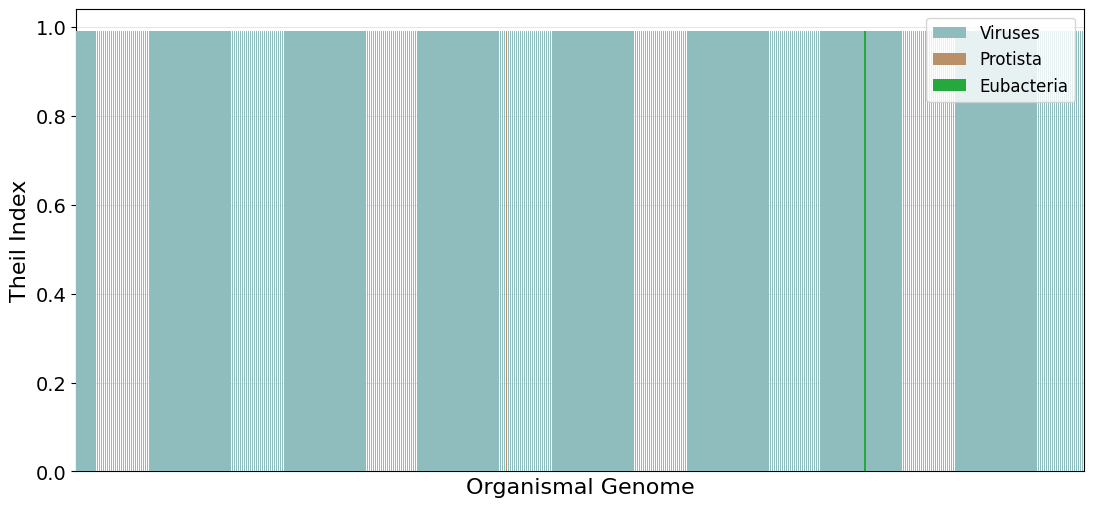

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
sns.barplot(data=gini_data.head(500), #width=0.99, 
                                x="#assembly_accession", 
                                y="gini_index", 
                                ax=ax, 
                                hue="kingdom_color", 
                                palette=kingdom_color_palette,
                                zorder=3)
ax.set_xticks([])
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Organismal Genome")
ax.set_ylabel("Theil Index")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.legend(title="", prop={"size": 12})
ax.tick_params(axis="y", which="major", labelsize=14)
# fig.savefig("/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/theil_index_kingdoms.png", bbox_inches='tight')

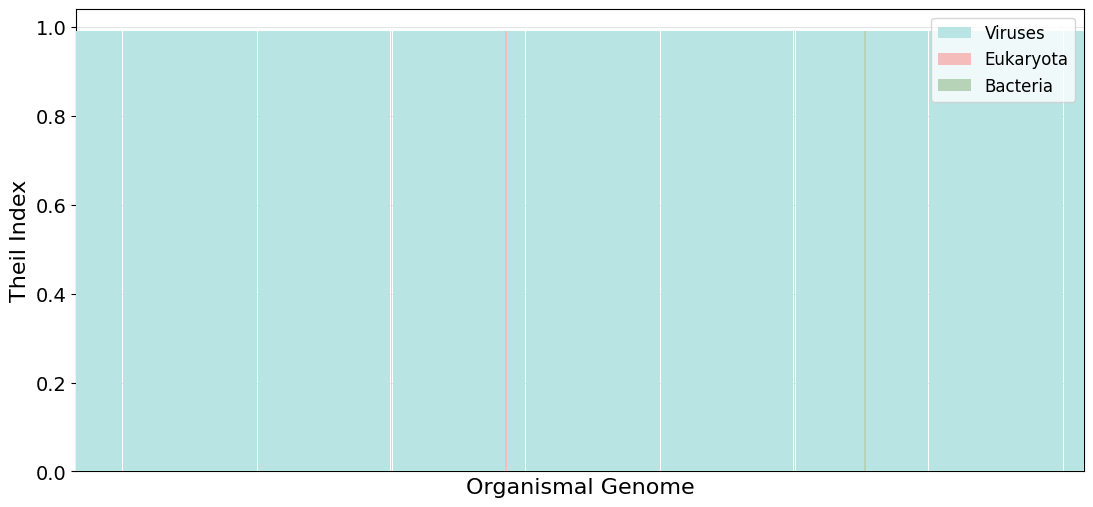

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
sns.barplot(data=gini_data.head(500), 
                        width=0.99, 
                                x="#assembly_accession", 
                                y="gini_index", 
                                ax=ax, 
                                hue="superkingdom", 
                                palette=domain_colors,
                                zorder=3)
ax.set_xticks([])
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Organismal Genome")
ax.set_ylabel("Theil Index")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.legend(title="", prop={"size": 12})
ax.tick_params(axis="y", which="major", labelsize=14)
# fig.savefig("/storage/group/izg5139/default/nicole/inverted_repeats/paper_figures/theil_index_domains.png", bbox_inches='tight')

In [300]:
grouped_kingdoms = gini_index_phylum.groupby("kingdom", as_index=False).agg(median_gini=("gini_index", "median"))\
                            .sort_values(by=["median_gini", "kingdom"], 
                                         ascending=False)
grouped_kingdoms

,kingdom,median_gini
6,Viruses,0.555778
1,Archaeabacteria,0.347838
2,Eubacteria,0.156229
3,Fungi,0.099109
5,Protista,0.096474
0,Animalia,0.044424
4,Plantae,0.037018


In [294]:
irp_df.query("phylum == 'Ascomycota'")['#assembly_accession'].shape

(296481,)

In [65]:
irp_df.loc[:, "ta"] = irp_df["sequenceof_arm"].apply(lambda x: (x.count("a") + x.count("t"))/len(x))
irp_df

,#assembly_accession,chromosome,start,end,organism_name,arm_size,genome_size,gc_percent,phylum,kingdom,...,cytosine,thymine,N,assembly_id,start_bin,end_bin,bin_size,ta_percent,bin_difference,ta
0,GCF_000002515.2,NC_006037.1,21717,21738,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,...,208091.0,325151.0,0.0,000002515.2,3,3,10625.90,0.909091,0,0.909091
1,GCF_000002515.2,NC_006037.1,141115,141141,Kluyveromyces lactis,11,10689156,38.5,Ascomycota,Fungi,...,208091.0,325151.0,0.0,000002515.2,14,14,10625.90,0.727273,0,0.727273
2,GCF_000002515.2,NC_006037.1,148944,148967,Kluyveromyces lactis,10,10689156,38.5,Ascomycota,Fungi,...,208091.0,325151.0,0.0,000002515.2,15,15,10625.90,0.800000,0,0.800000
3,GCF_000002515.2,NC_006037.1,151854,151885,Kluyveromyces lactis,14,10689156,38.5,Ascomycota,Fungi,...,208091.0,325151.0,0.0,000002515.2,15,15,10625.90,0.714286,0,0.714286
4,GCF_000002515.2,NC_006037.1,153811,153858,Kluyveromyces lactis,24,10689156,38.5,Ascomycota,Fungi,...,208091.0,325151.0,0.0,000002515.2,15,15,10625.90,0.583333,0,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24145416,GCF_963422545.1,NZ_OY730263.1,72153,72176,uncultured Flavobacterium sp.,10,5236164,33.0,Bacteroidota,Eubacteria,...,15549.0,30483.0,0.0,963422545.1,79,79,921.57,0.800000,0,0.800000
24145417,GCF_963422545.1,NZ_OY730263.1,75154,75185,uncultured Flavobacterium sp.,14,5236164,33.0,Bacteroidota,Eubacteria,...,15549.0,30483.0,0.0,963422545.1,82,82,921.57,0.785714,0,0.785714
24145418,GCF_963422545.1,NZ_OY730263.1,79156,79195,uncultured Flavobacterium sp.,18,5236164,33.0,Bacteroidota,Eubacteria,...,15549.0,30483.0,0.0,963422545.1,86,86,921.57,0.611111,0,0.611111
24145419,GCF_963422545.1,NZ_OY730263.1,87668,87694,uncultured Flavobacterium sp.,10,5236164,33.0,Bacteroidota,Eubacteria,...,15549.0,30483.0,0.0,963422545.1,96,96,921.57,0.900000,0,0.900000


In [295]:
mean_ta_content = irp_df.groupby("#assembly_accession").agg({"ta": "mean"})
theil_data = theil_data.merge(mean_ta_content, how="left", left_on="#assembly_accession", right_index=True)
theil_data

KeyError: "Column(s) ['ta'] do not exist"

UndefinedVariableError: name 'kingdom' is not defined

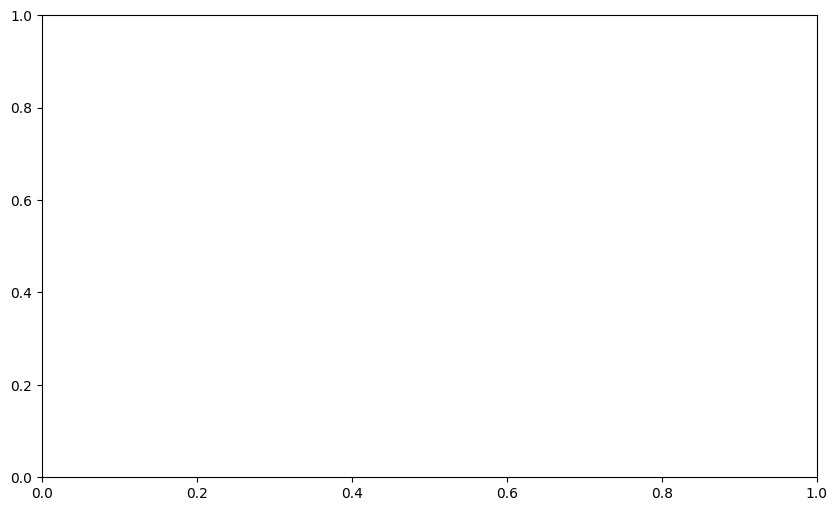

In [303]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.regplot(data=gini_data.query("kingdom == 'Fungi'"), x="gini_index", y="ta", color='#4d325e', ax=ax, line_kws={'lw': 2.5, 'linestyle': '--', 'color': '#16ABB5'})
ax.set_xlabel("Gini Index")
ax.set_ylabel("Average IRP TA Content (%)")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.grid(lw=0.4, alpha=0.4, zorder=0)
ax.set_title("Fungi")
ax.title.set_size(18)
ax.tick_params(axis="both", which="major", labelsize=12)
# fig.savefig("/storage/group/izg5139/default/nicole/inverted_repeats/paper_figures/fungi_theil_ta_scatterplot.png", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


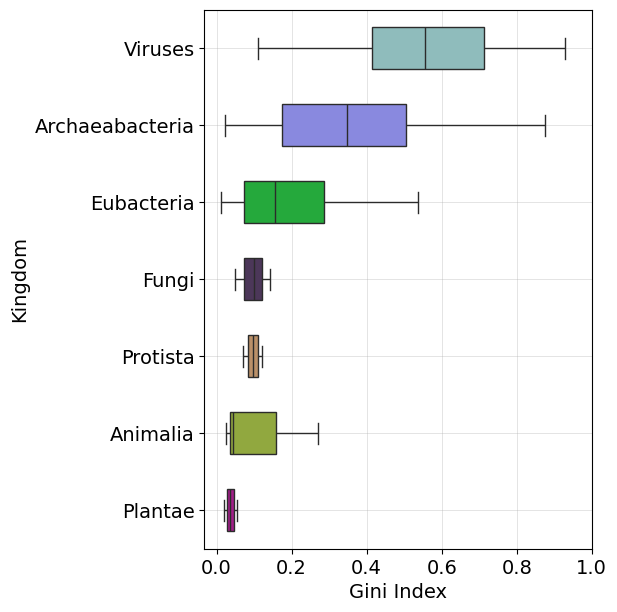

In [301]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 7))
gini_index_phylum["kingdom"] = pd.Categorical(gini_index_phylum["kingdom"], categories=grouped_kingdoms["kingdom"].tolist())
sns.boxplot(data=gini_index_phylum.sort_values(by=["kingdom"], ascending=False), 
                            hue="kingdom_color", 
                            y="kingdom", 
                            palette=kingdom_color_palette, 
                            x="gini_index", 
                            dodge=False,
                            width=0.55,
                            showfliers=False, 
                            zorder=3, 
            ax=ax)
ax.set_xlabel("Gini Index")
ax.set_ylabel("Kingdom")
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.set_xlim(xmax=1.0)
# ax.set_xticks(range(3), [0.0, 0.2, 0.4])
ax.legend(title="", prop={"size": 11}, frameon=False)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
fig.savefig("/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/gini_index_boxplot.png", bbox_inches='tight')

KeyError: 'kingdom'

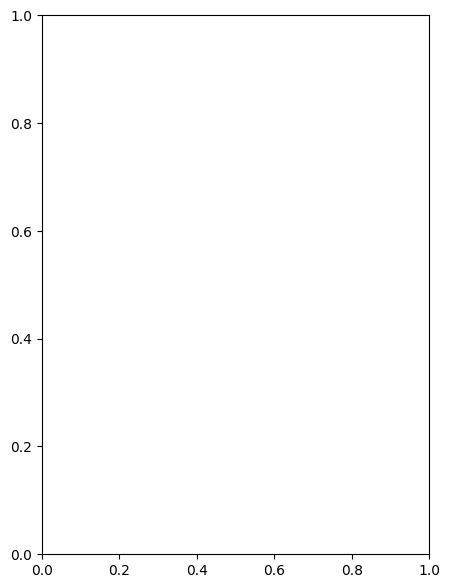

In [267]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 7))
theil_data["kingdom"] = pd.Categorical(theil_data["kingdom"], categories=grouped_kingdoms["kingdom"].tolist())
sns.boxplot(data=gini_data.sort_values(by=["kingdom"], ascending=False), 
                            hue="kingdom_color", 
                            y="kingdom", 
                            palette=kingdom_color_palette, 
                            x="theil_index", 
                            dodge=False,
                            showfliers=False, 
                            zorder=3, 
            ax=ax)
ax.set_xlabel("Theil Index")
ax.set_ylabel("Kingdom")
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.legend(title="", prop={"size": 11})
ax.tick_params(axis="both", which="major", labelsize=14)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
# fig.savefig("/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/theil_index_boxplot.png", bbox_inches='tight')

In [69]:
domain = "Eukaryota"

In [ ]:
bin_counts.query("organism_name=='Kluyveromyces lactis'")

In [ ]:
temp

In [ ]:
temp = bin_counts.query("phylum=='Ascomycota'")
temp

In [ ]:
theil_data

In [337]:
temp = count_bins.query("phylum=='Candidatus Verstraetearchaeota'")\
                            .groupby("bin", as_index=False)\
                            .agg({"bin_percentage": "mean"})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=temp, 
                                    x="bin", 
                                    y="bin_percentage", 
                                    color=domain_colors[domain],
                                    dodge=False, width=0.87, ax=ax, zorder=3)
ax.set_xticks([])
ax.set_title(domain)
ax.title.set_size(20)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Distance from chromosome ends")
ax.set_ylabel("IRP Percentage (%)")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.tick_params(axis="both", which="major", labelsize=11)

UndefinedVariableError: name 'phylum' is not defined

In [170]:
count_bins.query(f"superkingdom == '{domain}'")\
                                .groupby("bin", as_index=False)\
                                .agg({"bin_percentage": "mean"})

,bin,bin_percentage
0,1,27.147242
1,2,24.761743
2,3,24.271148
3,4,18.234869
4,5,12.751588
...,...,...
95,96,18.878106
96,97,18.631467
97,98,21.150732
98,99,23.444935


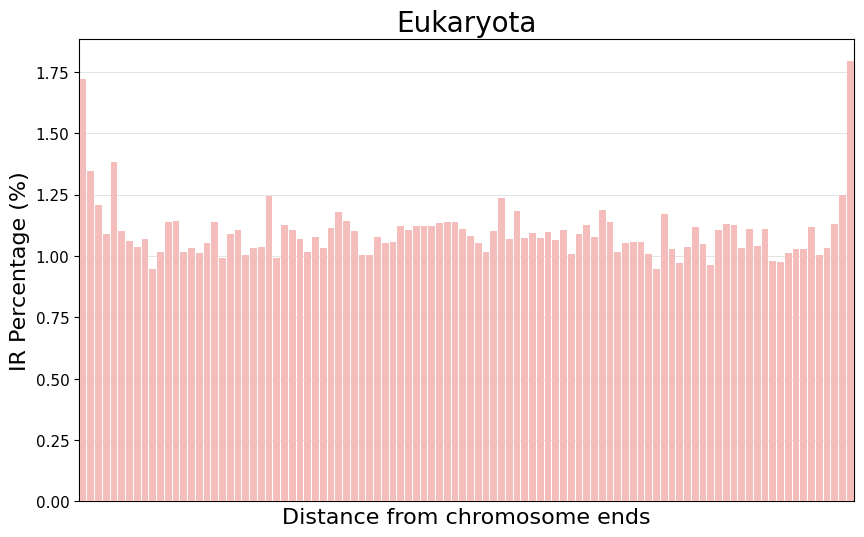

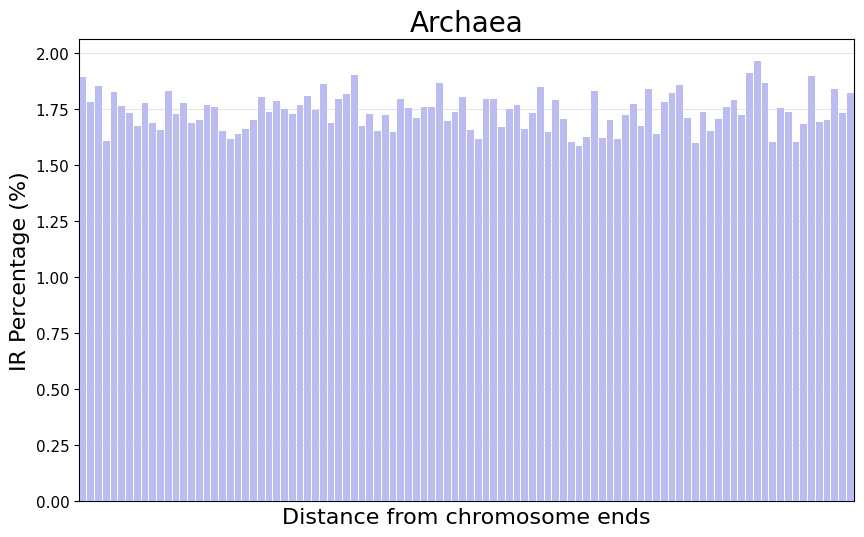

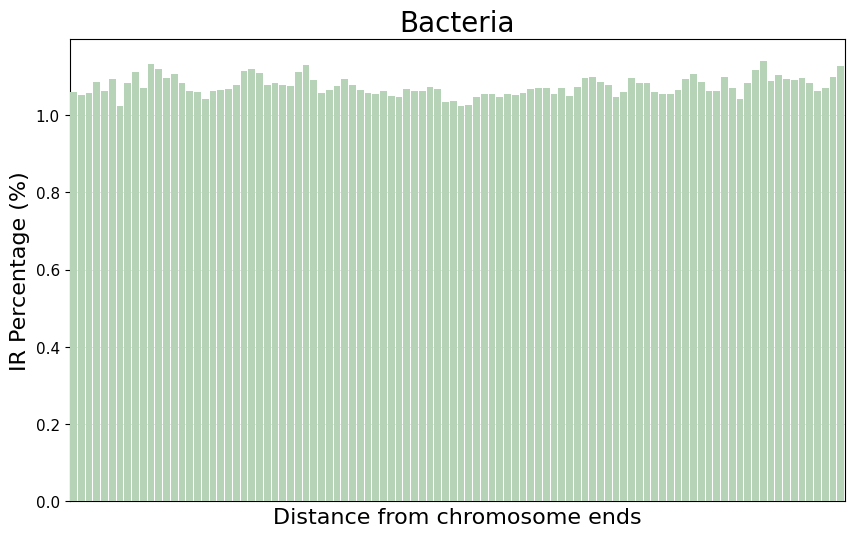

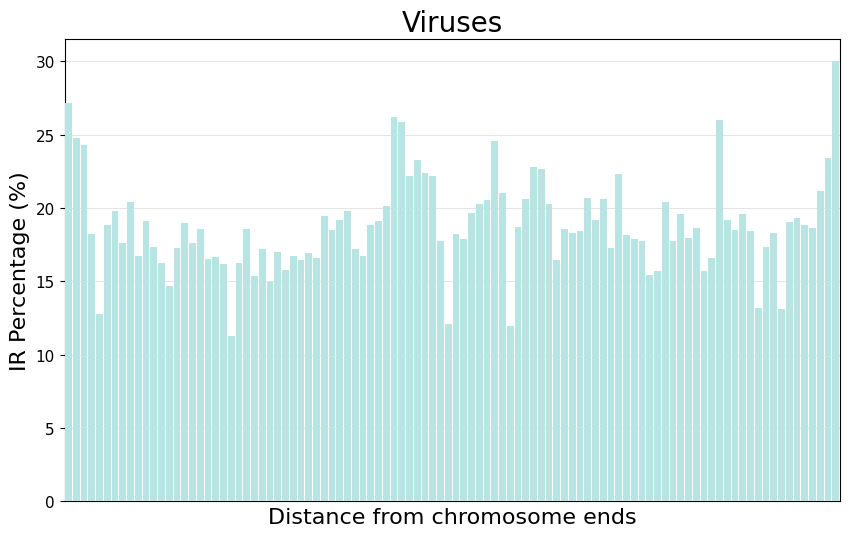

In [165]:
distances = {}

for domain in ["Eukaryota", "Archaea", "Bacteria", "Viruses"]:
    temp = count_bins.query(f"superkingdom == '{domain}'")\
                                .groupby("bin", as_index=False)\
                                .agg({"bin_percentage": "mean"})
    distances.update({domain: temp})
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    sns.barplot(data=distances[domain], 
                                        x="bin", 
                                        y="bin_percentage", 
                                        color=domain_colors[domain],
                                        dodge=False, width=0.87, ax=ax, zorder=3)
    ax.set_xticks([])
    ax.set_title(domain)
    ax.title.set_size(20)
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("Distance from chromosome ends")
    ax.set_ylabel("IR Percentage (%)")
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.tick_params(axis="both", which="major", labelsize=11)
    # fig.savefig(f"/storage/group/izg5139/default/nicole/inverted_repeats/paper_figures/{domain}_barplot_bin_position.png", bbox_inches='tight')

In [ ]:
bin_counts.query("organism_name=='Kluyveromyces lactis'")

In [ ]:
irp_df_.loc[:, ""]

In [ ]:
chromosome_metadata[chromosome_metadata['#assembly_accession'] == 'GCA_001936155.1']

In [ ]:
irp_df = irp_df.merge(chromosome_metadata, on=["#assembly_accession", "chromosome"], how="left")
irp_df

In [ ]:
irp_df[irp_df['total_bp'].isna()]["speciesID"].nunique()

In [ ]:
irp_df[irp_df["start"] > irp_df["max_start"]]

In [ ]:
10 15 20 90 110 --> 220


10/220, 15/220 , 20/220, 90/220, 110/220 -> 1/22 

# START OF IRP!
# C
0|-------------------------|1



In [ ]:
irp_df.loc[:, "relative_spawning_irp_start"] = 100 * irp_df['start'] / irp_df["max_start"]
irp_df.head()

In [ ]:
irp_df.loc[:, "relative_spawning_rounded"] = irp_df["relative_spawning_irp_start"].apply(math.floor)
irp_df

In [ ]:
calculate_theil(np.array([1, 2, 4, 5]))

In [ ]:
t = irp_df.groupby(["speciesID", "relative_spawning_rounded"], as_index=False).agg({"sequenceof_arm": "count", "superkingdom": "first"})
t

In [ ]:
print("HI")

In [ ]:
theil_indices = t.groupby("speciesID").agg({"sequenceof_arm": lambda ds: calculate_theil(ds.to_numpy()),
                                            "superkingdom": "first"})
theil_indices

In [ ]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10, 9))
sns.boxplot(data=theil_indices, 
            palette=domain_colors,
            x="superkingdom", 
            y="sequenceof_arm",
            ax=ax)
ax.set_xlabel("Domain")
ax.xaxis.label.set_size(22)
ax.set_ylabel("Theil Index")
ax.yaxis.label.set_size(22)
ax.set_ylim(ymax=1.0)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.grid(lw=0.4, alpha=0.6, zorder=0)

In [ ]:
cov_irp = irp_df.groupby(["speciesID", "chromosome"], as_index=False).agg(cov_start=("relative_spawning_irp_start", lambda ds: 100 * ds.std() / ds.mean()),
                                                                      start_mean=("relative_spawning_irp_start", "mean"),
                                                                        domain=("superkingdom", "first"),
                                                                     cov_end=("end", lambda ds: 100 * ds.std() / ds.mean()))\
                    .groupby("speciesID")\
                    .agg({"cov_start": "mean", 
                          "cov_end": "mean",
                          "start_mean": "mean",
                          "domain": "first"})
                                
cov_irp

In [ ]:
for domain in ["Eukaryota", "Viruses", "Archaea", "Bacteria"]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    
    sns.histplot(data=cov_irp.query(f"domain == '{domain}'"),
                 x="start_mean", stat="density", 
                 bins=30, 
                 color=domain_colors[domain],
                 kde=True, 
                 ax=ax,
                 line_kws={'color': 'crimson', 'lw': 4, 'ls': '--'})
    ax.set_title(domain.capitalize())
    ax.title.set_size(26)
    ax.lines[0].set_color('crimson')
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("IRP Spawning Site Mean")
    ax.set_ylabel("Density")
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)


In [ ]:
for domain in ["Eukaryota", "Viruses", "Archaea", "Bacteria"]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    
    sns.histplot(data=cov_irp.query(f"domain == '{domain}'"),
                 x="cov_start", stat="density", 
                 bins=30, 
                 color=domain_colors[domain],
                 kde=True, 
                 ax=ax,
                 line_kws={'color': 'crimson', 'lw': 4, 'ls': '--'})
    ax.set_title(domain.capitalize())
    ax.title.set_size(26)
    ax.lines[0].set_color('crimson')
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("IRP Spawning Site CV (%)")
    ax.set_ylabel("Density")
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)


# Theil Index

In [ ]:
def calculate_theil(stream):
    mean = stream.mean()
    return np.mean( stream / mean * np.log( stream / mean ) )

In [ ]:
mean_spawn_counts = irp_df.groupby("speciesID").agg(spawn_probable_position=("relative_irp_start_r", "mean"),
                                                   total_irp=("relative_irp_start_r", "count"))
mean_spawn_counts

In [ ]:
irp_df.loc[:, "relative_irp_start_r"] = irp_df["relative_spawning_irp_start"].apply(math.ceil)
irp_df

In [ ]:
irp_coverage = irp_df.groupby("speciesID").agg(arm_coverage=("arm_size", lambda ds: ds.sum() * 2),
                                              gap_coverage=("gap_size", lambda ds: ds.sum()),
                                              superkingdom=("superkingdom", "first"),
                                              kingdom=("kingdom", "first"),
                                               phylum=("phylum", "first"),
                                               genome_size=("genome_size", 'first'),
                                               organism_name=("organism_name", "first"),
                                               gc_content=("gc_percent", "first")
                                              )\
                .assign(irp_coverage=lambda df: df["arm_coverage"] + df["gap_coverage"])\
                .assign(total_coverage=lambda df: 100 * df["irp_coverage"].div(df["genome_size"]))\
                .sort_values(by=["total_coverage"], ascending=False)

irp_coverage

In [ ]:
irp_coverage.head(40)

In [ ]:
merged = irp_coverage.merge(mean_spawn_counts, left_index=True, right_index=True)
merged

In [ ]:
decomposed_kmers = pd.read_csv("/storage/group/izg5139/default/nicole/inverted_repeats/paper_data/decomposer_kmers_irp.csv", index_col="#assembly_accession")
decomposed_kmers

In [ ]:
for nucleotide in ["a", "g", "c", "t"]:
        decomposed_kmers.loc[:, f"{nucleotide}_prop"] = decomposed_kmers[nucleotide].div(decomposed_kmers["arm_size"])
    
decomposed_kmers.loc[:, "at_enrichment"] = decomposed_kmers["a"] / (decomposed_kmers["t"] + decomposed_kmers["a"])
decomposed_kmers.loc[:, "gc_enrichment"] = decomposed_kmers["g"] / (decomposed_kmers["g"] + decomposed_kmers["c"])
decomposed_kmers.loc[:, "ta_content"] = 100 * (decomposed_kmers["a"] + decomposed_kmers["t"]).div(decomposed_kmers["arm_size"])
decomposed_kmers.loc[:, "gc_content"] = 100 * (decomposed_kmers["g"] + decomposed_kmers["c"]).div(decomposed_kmers["arm_size"])

In [ ]:
decomposed_kmers["ta_content"].max()

In [ ]:
arm_10_sequences = decomposed_kmers.query(f"at_enrichment < {float('inf')} & gc_enrichment < {float('inf')}")

aggregated_nucleotide_counts = arm_10_sequences.groupby(arm_10_sequences.index)\
                            .agg({"a_prop": "mean", 
                                  "t_prop": "mean", 
                                  "c_prop": "mean", 
                                  "g_prop": "mean", 
                                  "at_enrichment": "mean",
                                  "gc_enrichment": "mean",
                                  "ta_content": "mean",
                                  "gc_content": "mean",
                                  "superkingdom": "first", 
                                  "phylum": "first", 
                                  "kingdom": "first",
                                  "genome_size": "first"
                                 }
                                )\
            .assign(total=lambda df: df[[f"{col}_prop" for col in {'a', 'c', 'g', 't'}]].sum(axis=1))

aggregated_nucleotide_counts

In [ ]:
aggregated_nucleotide_counts['ta_content'].max()

In [ ]:
merged.loc[:, "#assembly_accession"]  = merged.index.map(lambda x: '_'.join(x.split('_')[:2]))
merged

In [ ]:
merged_ = merged.drop(columns=["gc_content"]).merge(
    aggregated_nucleotide_counts[[f"{nucleotide}_prop" for nucleotide in ["a", "g", "c", "t"]] \
                                 + ["at_enrichment", "gc_enrichment"] \
                                + ["ta_content", "gc_content"]], 
    
            right_index=True, left_on="#assembly_accession", how="left")
merged_

In [ ]:
merged_["gc_content"].max(), merged_["ta_content"].max()

In [ ]:
for domain in ["Eukaryota", "Bacteria", "Viruses", "Archaea"]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    sns.regplot(data=merged_.query(f"superkingdom == '{domain}'"), 
                    x="spawn_probable_position", 
                y="ta_content", 
                color=domain_colors[domain],
                line_kws={'color': 'crimson', 'lw': 3.0, 'linestyle': '--'},
                ax=ax)
    ax.set_title(domain.capitalize())
    ax.title.set_size(26)
    ax.lines[0].set_color('crimson')
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("IRP Mean Start Site")
    ax.set_ylabel("TA Content (%)")
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)

    

In [ ]:
for domain in ["Eukaryota", "Bacteria", "Viruses", "Archaea"]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    sns.regplot(data=merged_.query(f"superkingdom == '{domain}'"), 
                    x="total_coverage", 
                y="ta_content", 
                line_kws={'color': 'crimson', 'lw': 3.0, 'linestyle': '--'},
                color=domain_colors[domain],
                ax=ax)
    ax.set_ylim(ymin=0, ymax=100)
    ax.set_title(domain.capitalize())
    ax.title.set_size(26)
    ax.lines[0].set_color('crimson')
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("IRP Coverage")
    ax.set_ylabel("TA Content (%)")
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)

# Calculation of DIRPs


Direct Inverted Repeats

In [ ]:
irp_df[irp_df['organism_name'].str.contains('Plasmodium')]

In [ ]:
irp_df['speciesID'].unique()

In [ ]:
irp_df.shape

In [ ]:
one_species = irp_df[(irp_df['speciesID'] == 'GCA_900632045.1_PfDd2-3_genomic') & (irp_df['chromosome'] == 'LR131303.1')].iloc[:, 2:]
one_species.loc[:, "ta_content"] = one_species["sequenceof_arm"].apply(lambda x: x.count("a") + x.count("t"))
one_species.loc[:, "ta_content"] = one_species["ta_content"].div(one_species["arm_size"])
one_species

In [ ]:
one_species['ta_content'].plot()

In [ ]:
import Levenshtein

In [ ]:
import numpy as np

next_ir = one_species[["start", "end", "sequenceof_arm", "gap_size", "ta_content"]]\
                .rename(columns={"start": "start_n", "end": "end_n", "sequenceof_arm": "sequenceof_arm_n", "gap_size": "gap_size_n", "ta_content": "ta_content_n"})\
            .assign(index=lambda df: df.index.map(lambda x: x-1))


with_next = one_species.merge(next_ir, 
                              left_index=True, 
                              right_on="index",
                              how="left",
                             )

from functools import partial


levensthein = partial(lambda x, y: Levenshtein.distance(x, y, score_cutoff=20))

with_next.loc[:, "distance"] = with_next[["sequenceof_arm", "sequenceof_arm_n"]].apply(lambda row: levensthein(row['sequenceof_arm'], row['sequenceof_arm_n']) if not \
                                                                                               ( isinstance(row['sequenceof_arm_n'], float) and math.isnan(row['sequenceof_arm_n'])) else np.nan, axis=1)
with_next

In [ ]:
with_next["distance"].plot(kind="hist")

In [ ]:
with_next.loc[:, "approximate"] = with_next["distance"].apply(lambda x: int(x <= 20))
with_next.loc[:, "direct_gap"] = with_next[["end", "start_n"]].apply(lambda row: row['start_n'] - row['end'], axis=1)
with_next.loc[:, "ta_shift"] = with_next["ta_content"] / with_next["ta_content_n"]

In [ ]:
import Levenshtein

In [ ]:
with_next[["start", "end", "start_n", "end_n", "gap_size", "gap_size_n", "sequenceof_arm", "sequenceof_arm_n", "distance", "approximate", "direct_gap"]]

In [ ]:
import seaborn as sns

In [ ]:
distance_counts = with_next.groupby("distance")\
                          .agg(counts=("start", "count"))
total = distance_counts["counts"].sum()
distance_counts.index = distance_counts.index.astype(int)
distance_counts["counts"] = distance_counts["counts"].div(total)
distance_counts = distance_counts.rename(columns={"counts": "Proportion (%)"})
distance_counts

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
sns.barplot(data=distance_counts.reset_index(),
                    x="distance",  
                    y="Proportion (%)",
             ax=ax, 
             width=0.8,)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Levenshtein Distance")
ax.set_ylabel("Density")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis="both", which="major", labelsize=17)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.histplot(data=with_next, x="direct_gap", 
             bins=80, 
             ax=ax, 
             stat='density', 
             kde=False, 
             zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlim(xmin=-10.0, xmax=3000)
ax.set_xlabel("Direct IRP Spacer")
ax.set_ylabel("Density")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis="both", which="major", labelsize=17)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))
with_next["ta_shift"].plot(ax=ax, zorder=3, color='lightblue', alpha=0.9)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", which="major", labelsize=17)
ax.axhline(1.0, linestyle='--', color='crimson', lw=4.0, zorder=4)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.histplot(data=with_next, x="ta_shift", 
             bins=20, 
             ax=ax, 
             stat='frequency', 
             kde=False, 
             zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Direct IRP Spacer")
ax.set_ylabel("Density")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis="both", which="major", labelsize=17)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(data=with_next, x="direct_gap", y="ta_shift",
             ax=ax, 
             zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Direct IRP Spacer")
ax.set_ylabel("Distance")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis="both", which="major", labelsize=17)

In [ ]:
with_next[["direct_gap"]].plot()

In [ ]:
with_next.reset_index()["approximate"].plot()

# Sankey Plot

In [ ]:
import sys

sys.path.append("pySankey/pysankey")
from sankey import sankey

sankey_species = irp_content_species[["superkingdom", "phylum", "mean_irp_content"]].dropna(axis=0).head(1_000)
sankey(
    left=sankey_species['superkingdom'], 
    right=sankey_species['phylum'],
    rightWeight=sankey_species['mean_irp_content'], 
    aspect=5,
    fontsize=20, 
    figureName="species"
)
# Res